# Expert Eval analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Actual Scores

### Dataset Organization

In [2]:
Expert_Eval_Data = pd.read_csv("/work/data/4) expert_eval/Expert Eval Compiled Dataset.csv")

Expert_Eval_Scores = pd.DataFrame()
Expert_Eval_Scores.insert(0, 'Medical Domain', 0)
Expert_Eval_Scores.insert(1, 'Test', 0)
Expert_Eval_Scores.insert(2, 'Final Score', 0)
Expert_Eval_Scores.insert(3, 'Type', 0)
Expert_Eval_Scores.insert(4, 'Source', 0)

for row_number in range(len(Expert_Eval_Data.index)):
    temp_row_list = Expert_Eval_Data.loc[row_number, :].values.flatten().tolist()
    scores = [temp_row_list[2], temp_row_list[3], temp_row_list[4]]
    final_score = 0

    for score in scores:
        if score == "No":
            final_score = final_score + 1
        if score == "Maybe":
            final_score = final_score + 2
        if score == "Yes":
            final_score = final_score + 3
    
    Expert_Eval_Scores.loc[len(Expert_Eval_Scores)] = [temp_row_list[0], temp_row_list[1], final_score, temp_row_list[5], temp_row_list[6]]

Expert_Eval_Scores.to_csv("/work/data/4) expert_eval/Expert Eval Scores.csv")

In [3]:
Expert_Eval_Scores_Data = pd.read_csv("/work/data/4) expert_eval/Expert Eval Scores.csv")

Expert_Eval_Scores_Data = Expert_Eval_Scores_Data.iloc[: , [1, 2, 3, 4, 5]].copy()

### Blind vs. Non-Blind Datasets

In [4]:
Blind_Expert_Eval_Scores = pd.DataFrame()
Blind_Expert_Eval_Scores.insert(0, 'Medical Domain', 0)
Blind_Expert_Eval_Scores.insert(1, 'Test', 0)
Blind_Expert_Eval_Scores.insert(2, 'Final Score', 0)
Blind_Expert_Eval_Scores.insert(3, 'Type', 0)
Blind_Expert_Eval_Scores.insert(4, 'Source', 0)

Non_Blind_Expert_Eval_Scores = pd.DataFrame()
Non_Blind_Expert_Eval_Scores.insert(0, 'Medical Domain', 0)
Non_Blind_Expert_Eval_Scores.insert(1, 'Test', 0)
Non_Blind_Expert_Eval_Scores.insert(2, 'Final Score', 0)
Non_Blind_Expert_Eval_Scores.insert(3, 'Type', 0)
Non_Blind_Expert_Eval_Scores.insert(4, 'Source', 0)

for row_number in range(len(Expert_Eval_Scores_Data.index)):
    temp_row_list = Expert_Eval_Scores_Data.loc[row_number, :].values.flatten().tolist()

    if temp_row_list[-2] == "Blind":
        Blind_Expert_Eval_Scores.loc[len(Blind_Expert_Eval_Scores)] = [temp_row_list[0], temp_row_list[1], temp_row_list[2], temp_row_list[3], temp_row_list[4]]
    
    if temp_row_list[-2] == "Non-Blind":
        Non_Blind_Expert_Eval_Scores.loc[len(Non_Blind_Expert_Eval_Scores)] = [temp_row_list[0], temp_row_list[1], temp_row_list[2], temp_row_list[3], temp_row_list[4]]

Blind_Expert_Eval_Scores.to_csv("/work/data/4) expert_eval/Final Scores/Blind - Expert Eval Scores.csv")
Non_Blind_Expert_Eval_Scores.to_csv("/work/data/4) expert_eval/Final Scores/Non-Blind - Expert Eval Scores.csv")

## Statistical Analysis + Graphs

### Install Stat Libraries

In [5]:


import itertools
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prerun_stats (sample_keys, group_label, data, y, stats_viz=False):

  ## Stats
  import scipy.stats as stats
  from pingouin import welch_anova, pairwise_gameshowell, pairwise_tukey
  from statistics import stdev
  import numpy as np
  
  MIN_SAMPLE_SIZE = 25
  TOLERANCE = 0.15

  sample_data = [data.copy().apply(lambda z: z[y] if z[group_label] == key else None, axis=1).dropna() for key in sample_keys]
  #sample_data = [data[data[group_label]==key][y] for key in sample_keys]


  sample_data_w_keys = pd.concat([pd.DataFrame({y:data.values, group_label:sample_keys[i]}) for i, data in enumerate(sample_data.copy())], axis=0, ignore_index=True)
  
  if stats_viz is True:
    print(f"Running stats between the samples: {sample_keys}")

  # Means for each sample group
  means_table = data[group_label].value_counts()

  # Check if *all* data points for each sample group are over 25
  sample_sizes_sufficient = all([sample > MIN_SAMPLE_SIZE for sample in means_table])

  # Check if means are equal within the TOLERANCE for each sample group
  sample_sizes_equal = all([abs(sample1 - sample2) < np.mean(means_table) * TOLERANCE for sample1, sample2 in itertools.combinations(means_table, 2)])

  # Dunn Test
  dunn = sp.posthoc_dunn(sample_data, p_adjust='bonferroni')
  replacer = {i+1:key for i, key in enumerate(sample_keys)}
  dunn.rename(columns = replacer, index=replacer, inplace=True)

  # Compile all stats into list
  statz = {'sample_sizes_sufficient': sample_sizes_sufficient,
          'sample_sizes_equal':      sample_sizes_equal,
          'shapiro':                 stats.shapiro(data[y]),
          'levene':                  stats.levene(*sample_data),
          'f_oneway':                stats.f_oneway(*sample_data),
          'kruskal':                 stats.kruskal(*sample_data),
          'welch_anova':             welch_anova(dv=y, between=group_label, data=sample_data_w_keys),
          'gameshowell':             pairwise_gameshowell(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'tukey':                   pairwise_tukey(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'dunn':                    dunn,
          'mean_std':                {key:{'mean' : np.mean(population), \
                                           'std' : stats.tstd(population)} for key, population in zip(sample_keys, sample_data)},
  }

  return statz



def stats_tree(sample_keys, sample_sizes_sufficient, sample_sizes_equal, shapiro, levene, f_oneway, kruskal, welch_anova, gameshowell, tukey, dunn, mean_std=None, stats_viz=False):

  import itertools

  ALPHA = 0.05
  indent = '   '


  if sample_sizes_sufficient or shapiro.pvalue > ALPHA:
    if stats_viz is True:
      print("> Sample size sufficient" if sample_sizes_sufficient else f">Sample size insufficient but *normality is met*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if sample_sizes_equal or levene.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes equal" if sample_sizes_equal else f"{indent*1}>Sample sizes not equal but *homogeneity is met*: s_levene={levene.statistic}, p_levene={levene.pvalue}")

      if f_oneway.pvalue < ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA (f_oneway) *significant*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}")
          print(f"\n> Thus running Tukey Test:")
          print(tukey)
          print(f"mean_std: {mean_std}")

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()
        
        return pairs, p_values

      elif f_oneway.pvalue > ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}" if stats_viz is True else "")
          print(f"mean_std: {mean_std}" )

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()

        return pairs, p_values

    elif not sample_sizes_equal or levene.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes are unequal and homogeneity *NOT MET*: w_levene={levene.statistic}, p_levene={levene.pvalue}")

      if welch_anova['p-unc'][0] < ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *SIGNIFICANT*: welch=\n{welch_anova}")#{welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"\n>Thus running Games-Howell test:")
          print(gameshowell)
          print(f"mean_std: {mean_std}")
        
        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

      elif welch_anova['p-unc'][0] > ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *NOT SIGNIFICANT*: welch=\n{welch_anova}")#F_welch={welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"mean_std: {mean_std}")

        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

  elif not sample_sizes_sufficient or shapiro.pvalue < ALPHA:
    if stats_viz is True:
      print(f"{indent*1}> Both minimum sample size and normality were *NOT MET*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if kruskal.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n Kruskal Wallis *SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"{indent*2}> Running DUNN test:")
        print(dunn)
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values

    elif kruskal.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n{indent*3}>Kruskal Wallis *NOT SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values



def plot_stats(pairs, p_values, y, x, hue=None, figsize=[4,8], ylim=None, **kwgs):

  from statannotations.Annotator import Annotator

  if figsize is None and hue is not None:
    figsize = [data[x].nunique()*data[hue].nunique()*1.2, 8]
  elif figsize is None and hue is None:
    figsize = [data[x].nunique()*1.2, 8]

  # plot 
  fig, ax = plt.subplots(figsize=figsize)
  plt.tight_layout()
  sns.barplot(ax=ax, **plot_params)
  annot = Annotator(ax, pairs, **plot_params)
  annot.configure(text_format="star", loc='outside', line_offset=True, line_offset_to_group=True, line_height=.01)
  annot.set_pvalues_and_annotate(p_values)

  # styling
  #ax.text(x=0.5, y=-0.3, s=lbl, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)

  ax.set_title(f"{y} for {x}")
  if hue is not None:
    ax.set_title(f"{y} for {x} by {hue.lower()}")


  if ylim is not None:
    ax.set_ylim(ylim)

  ax.get_legend().remove()
  ax.set_xlabel('')
  ax.set_ylabel('')

  plt.show()


def stats(data, y, x, hue=None, graph_viz=True, stats_viz=False, ylim=None, figsize=None, **kwgs):

  target_data = [data] # The data to be used for statistical analysis
  target_label = x # The column name with the groups to be compared between
  within_sample = [None] # The value of a column for hue groups to be compared within 

  if hue is not None:

    within_sample = data[x].unique()
    target_data = [data[data[x]==group] for group in within_sample]
    target_label = hue

  pairs = []
  p_values = []

  for i, data in enumerate(target_data):
    
    if stats_viz is True:
      print(f"----\nWithin the '{within_sample[i]}' group of '{x}':\n----" if len(within_sample) > 1 else "----")

    sample_keys = [key for key in data[target_label].unique()]
    stat_results = prerun_stats (sample_keys, target_label, data, y, stats_viz=stats_viz)
    pair, p_value = stats_tree(sample_keys, **stat_results, stats_viz=stats_viz)

    for pair_item, p_value_item in zip(pair, p_value):
      if hue is not None:
        pair_item = [pair_w_sample_label for pair_w_sample_label in itertools.product([within_sample[i]],pair_item)]
      pairs.append(pair_item)
      p_values.append(p_value_item)
    print("----" if stats_viz is True else "")

  if graph_viz:
    plot_stats(pairs, p_values, ylim=ylim, figsize=figsize, **plot_params)

print("Installation Complete")

Installation Complete


### Eval Scores - Graphs

In [6]:
Blind_Expert_Eval_Scores_Data = pd.read_csv("/work/data/4) expert_eval/Final Scores/Blind - Expert Eval Scores.csv")
Non_Blind_Expert_Eval_Scores_Data = pd.read_csv("/work/data/4) expert_eval/Final Scores/Non-Blind - Expert Eval Scores.csv")


In [7]:
palette = ["#a5b1b8", "#627682"]

----
Within the 'Accuracy' group of 'Test':
----
Running stats between the samples: ['AI', 'Doc']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.4734968354430378, p_bANOVA=0.22575593238671868
mean_std: {'AI': {'mean': 8.106666666666667, 'std': 0.9351213298636682}, 'Doc': {'mean': 8.24, 'std': 0.9671101351050038}}
----
----
Within the 'Strength' group of 'Test':
----
Running stats between the samples: ['AI', 'Doc']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.3243260648368776, p_bANOVA=0.5694483875493328
mean_std: {'AI': {'mean': 7.6466666666666665, 'std': 1.3216659543373985}, 'Doc': {'mean': 7.733333333333333, 'std': 1.3141801060853209}}
----
----
Within the 'Completeness' group of 'Test':
----
Running stats between the samples: ['AI', 'Doc']
> Sample size sufficient
   > Sample sizes equal
      > Thus runni

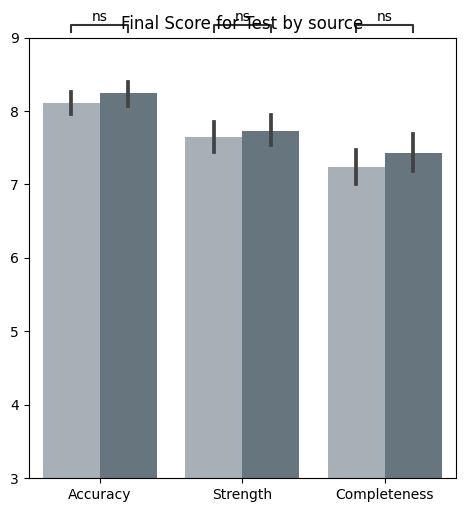

----
Within the 'Accuracy' group of 'Test':
----
Running stats between the samples: ['AI', 'Doc']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=56.54211035818005, p_bANOVA=6.50893933475847e-13

> Thus running Tukey Test:
    A    B  mean(A)  mean(B)  diff     se      T  p-tukey  hedges
0  AI  Doc      7.0     8.12 -1.12  0.149 -7.519      0.0  -0.866
mean_std: {'AI': {'mean': 7.0, 'std': 1.584319132654138}, 'Doc': {'mean': 8.12, 'std': 0.9042776790374565}}
----
----
Within the 'Strength' group of 'Test':
----
Running stats between the samples: ['AI', 'Doc']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=9.024721878862797, p_bANOVA=0.0028896003861456124

> Thus running Tukey Test:
    A    B  mean(A)  mean(B)   diff     se      T  p-tukey  hedges
0  AI  Doc    7.133      7.6 -0.467  0.155 -3.004    0.

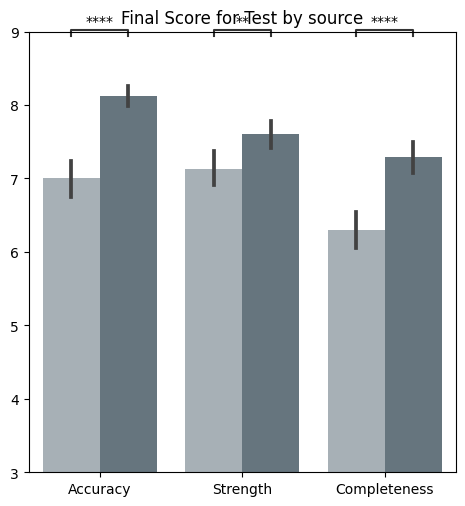

In [8]:
## Blind Dataset
plot_params = {
    'x': "Test",
    'y' : "Final Score",
    'hue' : 'Source',
    'data' : Blind_Expert_Eval_Scores_Data,
    'palette': palette,
    'order' : ['Accuracy', 'Strength', 'Completeness'],
    'hue_order' : ['AI', 'Doc'],
}

stats(**plot_params, graph_viz=True, ylim=[3,9], figsize=[5,5], stats_viz=True)



## Non-Blind Dataset
plot_params = {
    'x': "Test",
    'y' : "Final Score",
    'hue' : 'Source',
    'data' : Non_Blind_Expert_Eval_Scores_Data,
    'palette': palette,
    'order' : ['Accuracy', 'Strength', 'Completeness'],
    'hue_order' : ['AI', 'Doc'],
}

stats(**plot_params, graph_viz=True, ylim=[3,9], figsize=[5,5], stats_viz=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28896330-bd0f-4f0f-a160-af87c463253f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>